**1.1 (A) Install necessary libraries (2 Marks)**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [2]:
# Installation for GPU llama-cpp-python==0.3.30
#!CMAKE_ARGS="-DGGML_CUDA=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.3.0 numpy==1.26.4 --force-reinstall --no-cache-dir
!pip install -q --no-deps "xformers<0.0.27" "trl<0.9.0" peft==0.12.0 accelerate==0.32.1 bitsandbytes==0.43.2
!pip install rich
!pip install tqdm
# Installation for the huggingface-hub
!pip install huggingface-hub
# installation for the datasets
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install git+https://github.com/huggingface/transformers

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8tsbnbfc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8tsbnbfc
  Resolved https://github.com/huggingface/transformers to commit 70b07d97cf2c5f61fff55700b65528a1b6845cd2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**1.1 (B) Import necessary libraries (2 Marks)**

In [4]:
from huggingface_hub import hf_hub_download
from huggingface_hub import notebook_login
#notebook_login()

In [5]:
import pandas as pd
import numpy as np
import torch

In [6]:
# Using meta-llama/Llama-3.2-11B-Vision-Instruct model

import requests
import torch
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

device = 'cuda'
dtype = torch.bfloat16

model_id = "meta-llama/Llama-3.2-11B-Vision-Instruct"
model = MllamaForConditionalGeneration.from_pretrained(model_id, device_map=device, torch_dtype=dtype)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

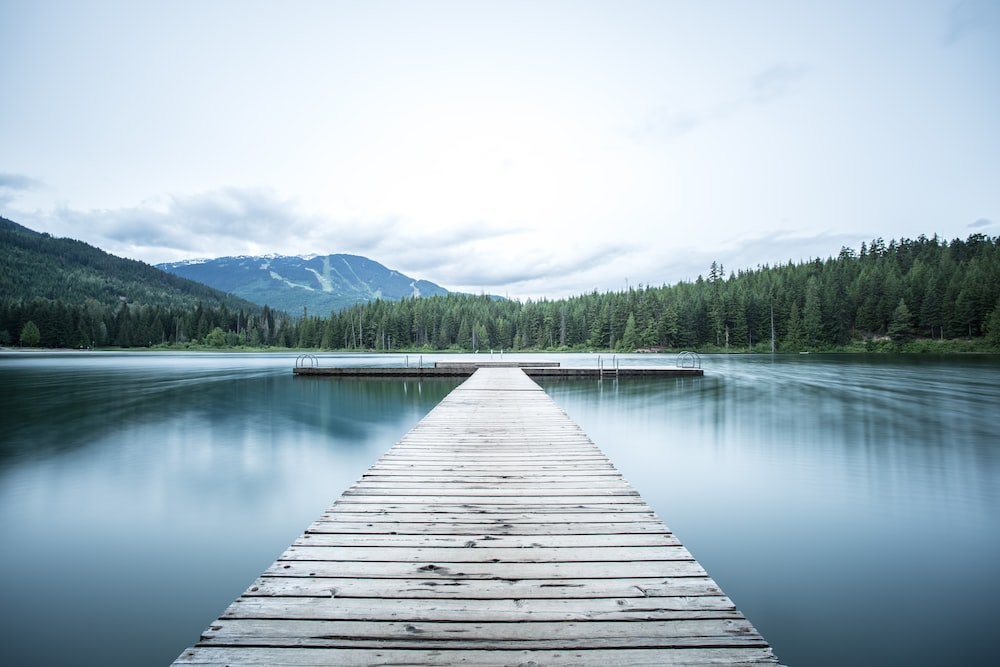

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>What does the image show?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The image depicts a serene lake scene, featuring a long wooden dock extending into the water, with a mountain range in the background


In [9]:
messages = [
    [
        {
            "role": "user", 
            "content": [
                {"type": "image"},
                {"type": "text", "text": "What does the image show?"}
            ]
        }
    ],
]
text = processor.apply_chat_template(messages, add_generation_prompt=True)

url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
output = model.generate(**inputs, max_new_tokens=25)
print(processor.decode(output[0]))

## Testing if the model can read the text on an image from a news outlet ##

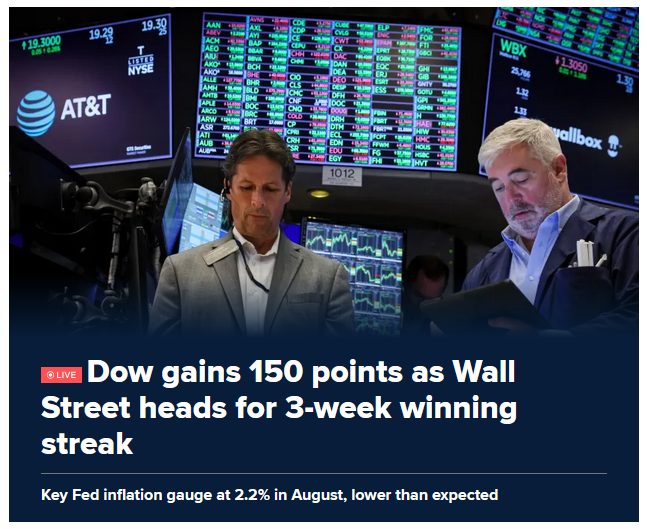

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>Please read the text on the image.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The image shows a news headline about the stock market, with the title "Dow gains 150 points as Wall Street heads for 3-week winning streak" in white text at the bottom of the image. 

*   The headline is written in white text and reads: 
    *   "Dow gains 150 points as Wall Street heads for 3-week winning streak"
*   Below the headline, there is a subheading that reads: 
    *   "Key Fed inflation gauge at 2.2% in August, lower than expected"
*   The background of the image features a photograph of two men in suits


In [10]:
messages = [
    [
        {
            "role": "user", 
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Please read the text on the image."}
            ]
        }
    ],
]
text = processor.apply_chat_template(messages, add_generation_prompt=True)

image = Image.open(r"Image_1.png")
image.show()

inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
output = model.generate(**inputs, max_new_tokens=128)
print(processor.decode(output[0]))

## Testing if the model can read the text on an image and translate it to Spanish ##

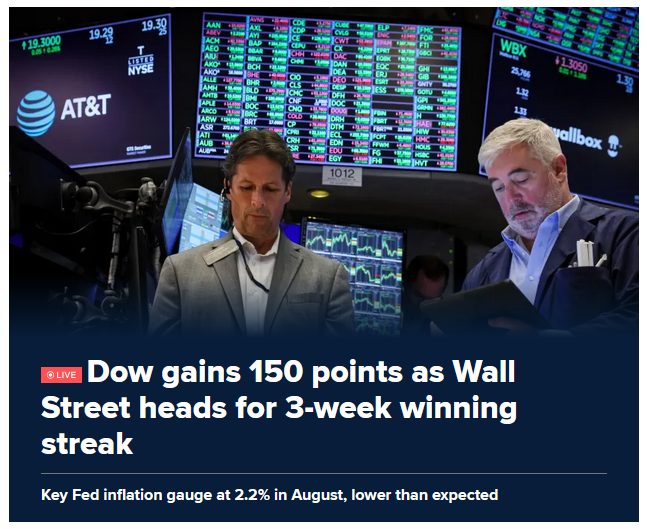

<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

<|image|>Please read the text on the image and translate it to Spanish.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The text in the image reads:

"Dow gains 150 points as Wall Street heads for 3-week winning streak"

Translation to Spanish:

"El Dow gana 150 puntos mientras Wall Street se dirige a una racha ganadora de 3 semanas"

This translation maintains the original meaning and structure of the text, conveying the same information in Spanish.<|eot_id|>


In [11]:
messages = [
    [
        {
            "role": "user", 
            "content": [
                {"type": "image"},
                {"type": "text", "text": "Please read the text on the image and translate it to Spanish."}
            ]
        }
    ],
]
text = processor.apply_chat_template(messages, add_generation_prompt=True)

image = Image.open(r"Image_1.png")
image.show()

inputs = processor(text=text, images=image, return_tensors="pt").to(model.device)
output = model.generate(**inputs, max_new_tokens=128)
print(processor.decode(output[0]))

## Testing a PDF containing an Invoice ##

In [ ]:
import fitz
import io
from PIL import Image

messages = [
    [
        {
            "role": "user", 
            "content": [
                {"type": "image"},
                {"type": "text", "text": "The image is an invoice. Please read the text and extract the relevant information."}
            ]
        }
    ],
]
text = processor.apply_chat_template(messages, add_generation_prompt=True)

pdf_file = fitz.open(r"invoice.pdf")
page = pdf_file.load_page(0)  # load the first page
image_list = page.get_images(full=True)  # get images on the page

for page_number in range(len(pdf_file)): 
    page=pdf_file[page_number]
    image_list = page.get_images()
    print(image_list)
    
    for image_index, img in enumerate(page.get_images(),start=1):
        print(image_index)
        xref = img[0] 
        # extract image bytes 
        base_image = pdf_file.extract_image(xref)
        image_bytes = base_image["image"]
        # get image extension
        image_ext = base_image["ext"]
        
        # Create a PIL Image object from the image bytes
        pil_image = Image.open(io.BytesIO(image_bytes))

inputs = processor(text=text, images=pil_image, return_tensors="pt").to(model.device)
output = model.generate(**inputs, max_new_tokens=128)
print(processor.decode(output[0]))